In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    properties = torch.cuda.get_device_properties(0)
    compute_capability = f"{properties.major}.{properties.minor}"
    total_memory = properties.total_memory / 1024**3

    print(f"CUDA Device: {device_name}")
    print(f"CUDA Compute Capability: {compute_capability}")
    print(f"Total Memory: {total_memory:.2f} GB")
else:
    print("GPU is not available")

PyTorch Version: 2.4.1+cu121
CUDA Device: NVIDIA GeForce RTX 2060
CUDA Compute Capability: 7.5
Total Memory: 5.61 GB


### MNIST Dataset

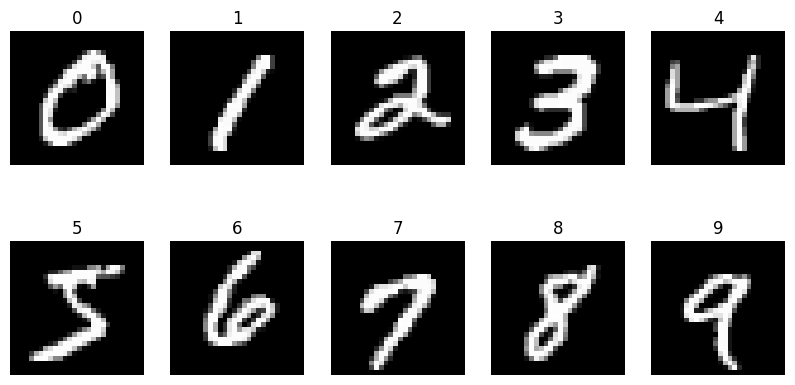

In [3]:
# load MNIST dataset from utils
from utils import get_dataset

channel, im_size, num_classes, class_names, mean, std, train_MNIST_dataset, test_MNIST_dataset, test_MNIST_dataloader = get_dataset('MNIST', '../datasets')

# visualize 10 classes of MNIST (2 by 5)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_MNIST_dataset.data[train_MNIST_dataset.targets == i][0], cmap='gray')
    ax.set_title(f"{i}")
    ax.axis('off')

### MHIST Dataset

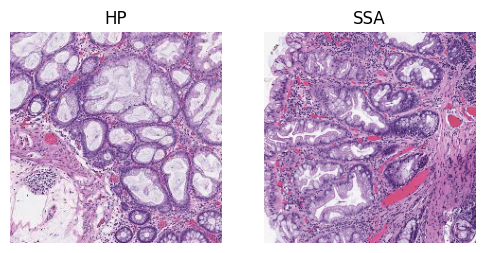

In [23]:
# load MHIST dataset from MHISTDataset class
import MHISTDataset

train_MHIST_dataset = MHISTDataset.MHISTDataset('../mhist_dataset/images-split/train', transform=None)
test_MNIST_dataset = MHISTDataset.MHISTDataset('../mhist_dataset/images-split/test', transform=None)

# find train_MHIST_dataset with "HP" label, train_MHHIST_dataset[i][2]
HP_indices = [i for i in range(len(train_MHIST_dataset)) if train_MHIST_dataset[i][2] == 'HP']
SSA_indices = [i for i in range(len(train_MHIST_dataset)) if train_MHIST_dataset[i][2] == 'SSA']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(train_MHIST_dataset[HP_indices[0]][0])
axes[0].set_title("HP")
axes[0].axis('off')
axes[1].imshow(train_MHIST_dataset[SSA_indices[0]][0])
axes[1].set_title("SSA")
axes[1].axis('off')
plt.show()